In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import os

In [2]:
path_prefix = os.getcwd() + '/simulation-runs'

In [3]:
vcc = 3 # Tensão de alimentaçaõ em V
rx_current = 21.8 / 1000 # Consumo de corrente do rádio em rx em Ampére
tx_current = 19.5 / 1000 # Consumo de corrente do rádio em tx em Ampére
cpu_sleep_current = 5.1/ 1000000 # Consumo de corrente do rádio em sleep (standby) em Ampére
cpu_idle_current = 54.5 / 1000000 # Consumo de corrente do rádio em idle em Ampére

ticks_per_second = 32768 # Um segundo em clocks do nó
powertrace_sample_rate = 10 # Período de envio de mensagens em segundos
Nb = 52 # Número de bytes por mensagem
packet_size_in_bits = 8 * Nb # Tamanho da mensagem em bits

In [4]:
def read_csv_in_folder(folder_path):
  dfs = []
  for filename in os.listdir(folder_path):
    # Se o arquivo é um arquivo CSV
    if filename.endswith('.csv'):
        # Construir o caminho completo para o arquivo
        file_path = os.path.join(folder_path, filename)
        
        # Ler o arquivo CSV e armazenar o DataFrame na lista
        df = pd.read_csv(file_path)
        dfs.append(df)
  return dfs

In [5]:
aloha_duty_cycles = ["1", "3", "5", "10", "20", "30", "40", "50", "60"]
aloha_rdc_dfs = {}

for rdc in aloha_duty_cycles:
  path = path_prefix + "/" + rdc + "-duty-cycle"
  aloha_rdc_dfs[rdc] = read_csv_in_folder(path)

In [6]:
csma_dfs = read_csv_in_folder(path_prefix + "/csma")
aloha_always_on_dfs = read_csv_in_folder(path_prefix + "/aloha-always-on")

In [7]:
def concat_dfs(dfs):
  return pd.concat(dfs, ignore_index=True)

In [8]:
# Concat dfs
aloha_rdc_dfs_concat = {}
for rdc in aloha_duty_cycles:
  aloha_rdc_dfs_concat[rdc] = concat_dfs(aloha_rdc_dfs[rdc])

csma_df_concat = pd.concat(csma_dfs, ignore_index=True)
aloha_always_on_df_concat = pd.concat(aloha_always_on_dfs, ignore_index=True)

In [9]:
# Cálculo do consumo de corrente em Ampére
def calculate_energy_comsuption(df):
  charge = (df['cpu'] * cpu_idle_current + df['transmit'] * tx_current + df['listen'] * rx_current + df['lpm'] * cpu_sleep_current) / (ticks_per_second)
  return charge * vcc

In [10]:
energy_unit = 'J'

In [11]:
#Cálculo de potência de cada linha
for rdc in aloha_duty_cycles:
  aloha_rdc_dfs_concat[rdc]['Eihop'] = calculate_energy_comsuption(aloha_rdc_dfs_concat[rdc]) # Energia em J
  aloha_rdc_dfs_concat[rdc]['Eihop/bit'] = aloha_rdc_dfs_concat[rdc]['Eihop'] / packet_size_in_bits # Energia por bit em J/bit
  aloha_rdc_dfs_concat[rdc]['P0'] = aloha_rdc_dfs_concat[rdc]['Eihop'] / powertrace_sample_rate # Potência em W

csma_df_concat['Eihop'] = calculate_energy_comsuption(csma_df_concat) # Energia em J
csma_df_concat['Eihop/bit'] = csma_df_concat['Eihop'] / packet_size_in_bits # Energia por bit em J/bit
csma_df_concat['P0'] = csma_df_concat['Eihop'] / powertrace_sample_rate # Potência em W

aloha_always_on_df_concat['Eihop'] = calculate_energy_comsuption(aloha_always_on_df_concat) # Energia em J
aloha_always_on_df_concat['Eihop/bit'] = aloha_always_on_df_concat['Eihop'] / packet_size_in_bits # Energia por bit em J/bit
aloha_always_on_df_concat['P0'] = aloha_always_on_df_concat['Eihop'] / powertrace_sample_rate # Potência em W

In [12]:
columns_to_drop = ['cpu', 'transmit', 'listen', 'lpm']
aloha_rdc_final_dfs = {}
for rdc in aloha_duty_cycles:
  aloha_rdc_final_dfs[rdc] = aloha_rdc_dfs_concat[rdc].drop(columns=columns_to_drop)

csma_df_final = csma_df_concat.drop(columns=columns_to_drop)
aloha_always_on_df_final = aloha_always_on_df_concat.drop(columns=columns_to_drop)

In [13]:
# For 95% confidence interval when n = 10 (11 samples)
z = 2.228
n = 11

In [14]:
def plot_error_bar(ax, mean, margin_of_error, title, x_label, y_label):
  ax.errorbar(0, mean, yerr=margin_of_error, fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0)
  ax.set_title(title)
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)

In [15]:
def calculate_mean_and_margin_of_error(data):
  mean = data.mean()
  std = data.std()
  margin_of_error = z * (std / np.sqrt(n))
  return mean, margin_of_error

In [16]:
aloha_mean_and_margin_of_error = {}
for rdc in aloha_duty_cycles:
  aloha_mean_and_margin_of_error[rdc] = calculate_mean_and_margin_of_error(aloha_rdc_final_dfs[rdc]['Eihop/bit'])

csma_mean_and_margin_of_error = calculate_mean_and_margin_of_error(csma_df_final['Eihop/bit'])
aloha_always_on_mean_and_margin_of_error = calculate_mean_and_margin_of_error(aloha_always_on_df_final['Eihop/bit'])

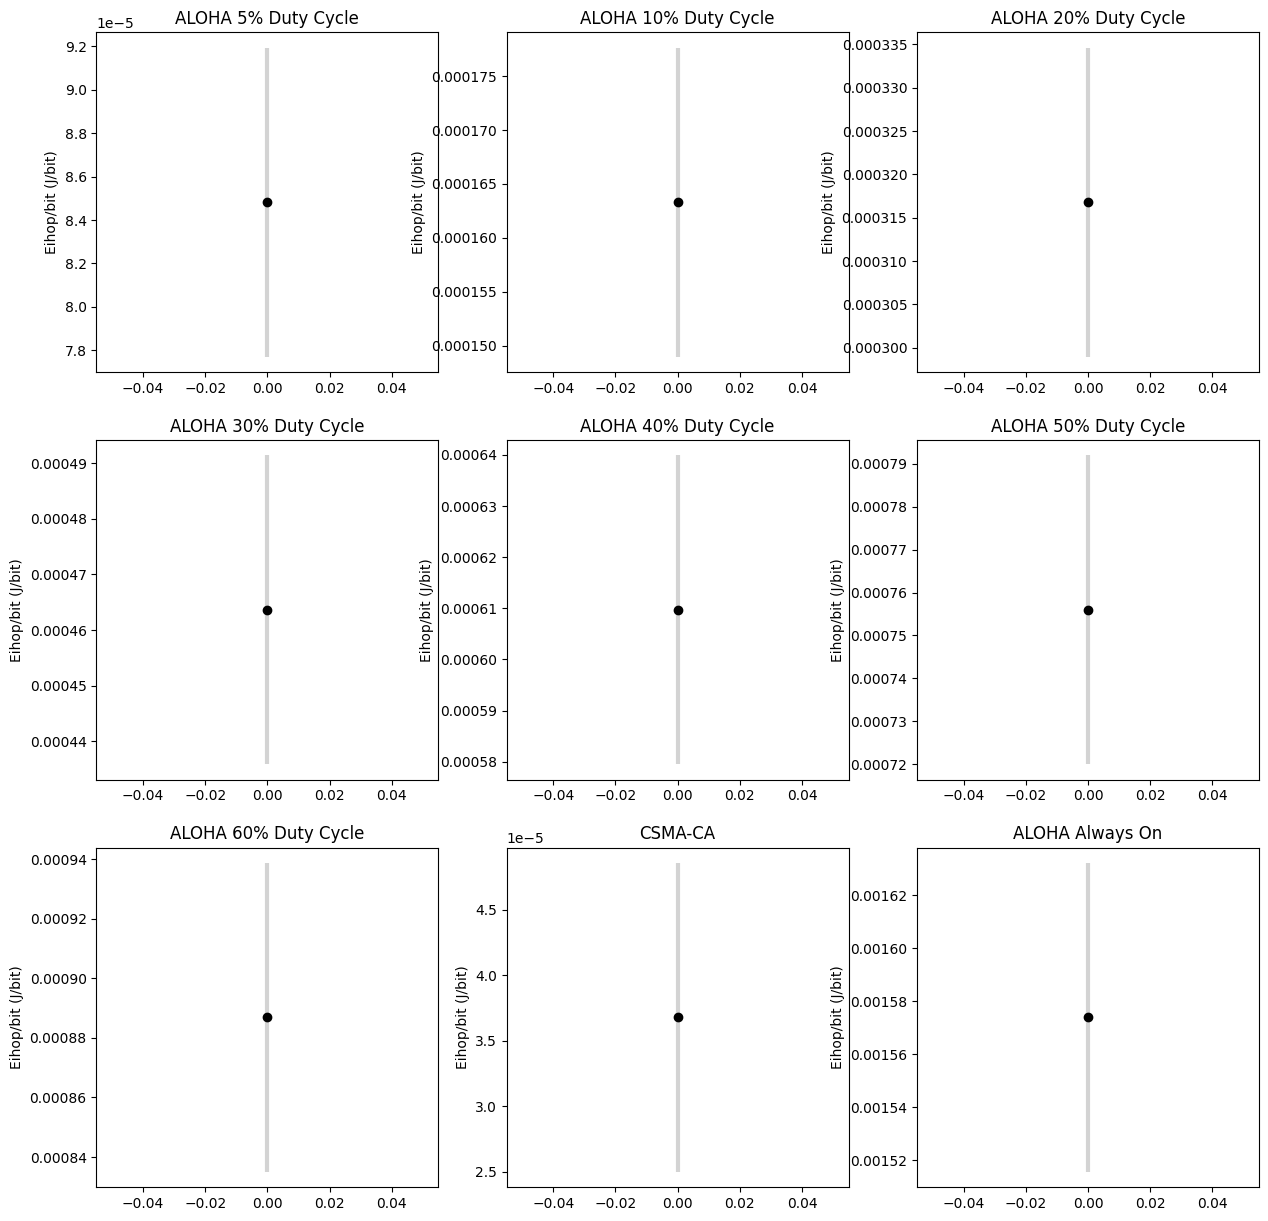

In [17]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

plot_error_bar(axs[0,0], aloha_mean_and_margin_of_error["5"][0], aloha_mean_and_margin_of_error["5"][1],   'ALOHA 5% Duty Cycle',  '', f'Eihop/bit ({energy_unit}/bit)')
plot_error_bar(axs[0,1], aloha_mean_and_margin_of_error["10"][0], aloha_mean_and_margin_of_error["10"][1], 'ALOHA 10% Duty Cycle', '', f'Eihop/bit ({energy_unit}/bit)')
plot_error_bar(axs[0,2], aloha_mean_and_margin_of_error["20"][0], aloha_mean_and_margin_of_error["20"][1], 'ALOHA 20% Duty Cycle', '', f'Eihop/bit ({energy_unit}/bit)')
plot_error_bar(axs[1,0], aloha_mean_and_margin_of_error["30"][0], aloha_mean_and_margin_of_error["30"][1], 'ALOHA 30% Duty Cycle', '', f'Eihop/bit ({energy_unit}/bit)')
plot_error_bar(axs[1,1], aloha_mean_and_margin_of_error["40"][0], aloha_mean_and_margin_of_error["40"][1], 'ALOHA 40% Duty Cycle', '', f'Eihop/bit ({energy_unit}/bit)')
plot_error_bar(axs[1,2], aloha_mean_and_margin_of_error["50"][0], aloha_mean_and_margin_of_error["50"][1], 'ALOHA 50% Duty Cycle', '', f'Eihop/bit ({energy_unit}/bit)')
plot_error_bar(axs[2,0], aloha_mean_and_margin_of_error["60"][0], aloha_mean_and_margin_of_error["60"][1], 'ALOHA 60% Duty Cycle', '', f'Eihop/bit ({energy_unit}/bit)')

plot_error_bar(axs[2,1], csma_mean_and_margin_of_error[0], csma_mean_and_margin_of_error[1], 'CSMA-CA', '', f'Eihop/bit ({energy_unit}/bit)')
plot_error_bar(axs[2,2], aloha_always_on_mean_and_margin_of_error[0], aloha_always_on_mean_and_margin_of_error[1], 'ALOHA Always On', '', f'Eihop/bit ({energy_unit}/bit)')

In [18]:
def plot_error_bar(x, mean, margin_of_error, label, color=None):
    if color:
        plt.errorbar(x, mean, yerr=margin_of_error, fmt='o', label=label, color=color)
    else:
        plt.errorbar(x, mean, yerr=margin_of_error, fmt='o', label=label)

In [19]:
aloha_duty_cycles_to_print = ["1", "3", "5", "10", "20", "50"]

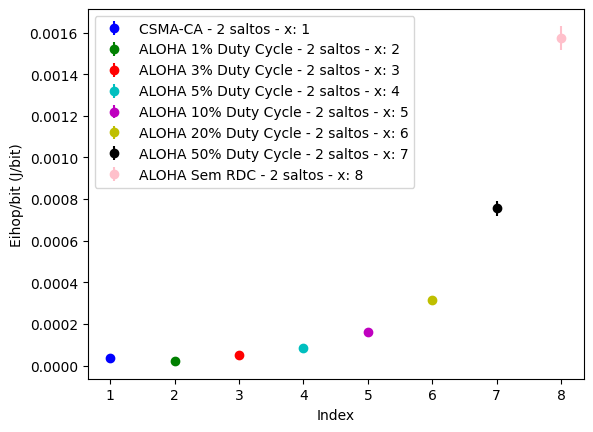

In [73]:
# Dados para plotar

aloha_labels = [f'ALOHA {dc}% Duty Cycle - 2 saltos - x: {i + 2}' for i, dc in enumerate(aloha_duty_cycles_to_print)]
csma_label = 'CSMA-CA - 2 saltos - x: 1'
aloha_always_on_label = 'ALOHA Sem RDC - 2 saltos - x: 8'

# Plotar os gráficos
x = 1
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown', 'pink']
plot_error_bar(x, csma_mean_and_margin_of_error[0], csma_mean_and_margin_of_error[1], csma_label, colors[0])
for dc, label, color in zip(aloha_duty_cycles_to_print, aloha_labels, colors[1:]):
    x += 1
    plot_error_bar(x, aloha_mean_and_margin_of_error[dc][0], aloha_mean_and_margin_of_error[dc][1], label, color)
plot_error_bar(x + 1, aloha_always_on_mean_and_margin_of_error[0], aloha_always_on_mean_and_margin_of_error[1], aloha_always_on_label, colors[-1])

# Adicionar uma legenda
plt.legend()

# Adicionar rótulos para os eixos
plt.xlabel('Index')
plt.ylabel(f'Eihop/bit ({energy_unit}/bit)')

# Mostrar o gráfico
plt.show()

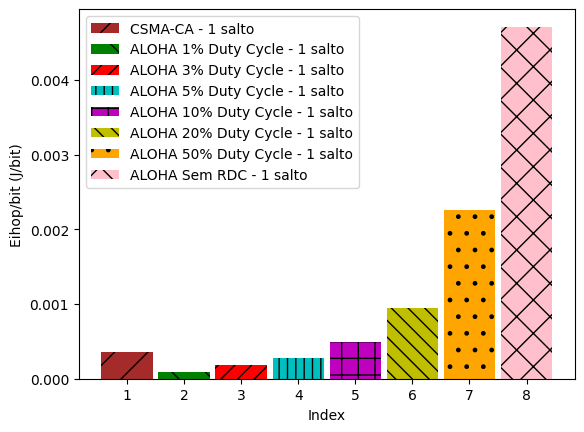

<Figure size 5000x5000 with 0 Axes>

In [70]:
# 1 hop

aloha_labels = [f'ALOHA {dc}% Duty Cycle - 1 salto' for dc in aloha_duty_cycles_to_print]
csma_label = 'CSMA-CA - 1 salto'
aloha_always_on_label = 'ALOHA Sem RDC - 1 salto'
bar_width = 0.9

# Plotar os gráficos
colors = ['brown', 'g', 'r', 'c', 'm', 'y', 'orange', 'purple', 'pink']
hatches = ['/', '\\', '//', '||', '+', '\\\\', '.', 'O', 'X']
x = 1
df = csma_df_final[csma_df_final['hops'] == 1]
plt.bar(x, df['Eihop/bit'], bar_width, label=csma_label, color=colors[0], hatch=hatches[0])
for dc, label, color, hatch in zip(aloha_duty_cycles_to_print, aloha_labels, colors[1:], hatches[1:]):
    x += 1
    df = aloha_rdc_final_dfs[dc][aloha_rdc_final_dfs[dc]['hops'] == 1]
    plt.bar(x, df['Eihop/bit'], bar_width,  label=label, color=color, hatch=hatch)
df = aloha_always_on_df_final[aloha_always_on_df_final['hops'] == 1]
plt.bar(x + 1, df['Eihop/bit'], bar_width, label=aloha_always_on_label, color=colors[-1], hatch=hatches[-1])


# Adicionar uma legenda
plt.legend()

# Adicionar rótulos para os eixos
plt.xlabel('Index')
plt.ylabel(f'Eihop/bit ({energy_unit}/bit)')
plt.figure(figsize=(50,50))
# Mostrar o gráfico
plt.show()


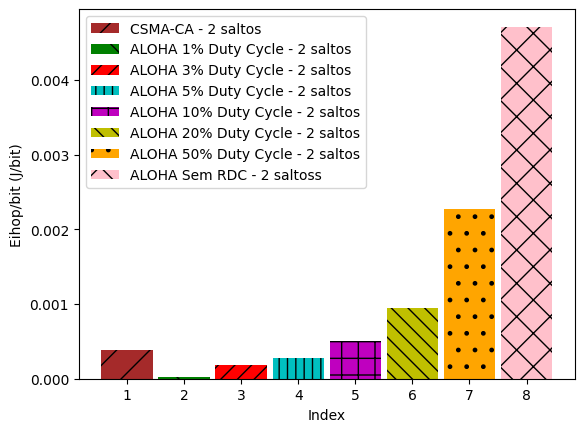

In [71]:
# 2 hop

aloha_labels = [f'ALOHA {dc}% Duty Cycle - 2 saltos' for i, dc in enumerate(aloha_duty_cycles_to_print)]
csma_label = 'CSMA-CA - 2 saltos'
aloha_always_on_label = 'ALOHA Sem RDC - 2 saltoss'
bar_width = 0.9
# Plotar os gráficos
colors = ['brown', 'g', 'r', 'c', 'm', 'y', 'orange', 'purple', 'pink']
hatches = ['/', '\\', '//', '||', '+', '\\\\', '.', 'O', 'X']
x = 1
df = csma_df_final[csma_df_final['hops'] == 2]
plt.bar(x, df['Eihop/bit'], bar_width, label=csma_label, color=colors[0], hatch=hatches[0])
for dc, label, color, hatch in zip(aloha_duty_cycles_to_print, aloha_labels, colors[1:], hatches[1:]):
    x += 1
    df = aloha_rdc_final_dfs[dc][aloha_rdc_final_dfs[dc]['hops'] == 2]
    plt.bar(x, df['Eihop/bit'], bar_width,  label=label, color=color, hatch=hatch)

df = aloha_always_on_df_final[aloha_always_on_df_final['hops'] == 2]
plt.bar(x + 1, df['Eihop/bit'], bar_width, label=aloha_always_on_label, color=colors[-1], hatch=hatches[-1])


# Adicionar uma legenda
plt.legend()

# Adicionar rótulos para os eixos
plt.xlabel('Index')
plt.ylabel(f'Eihop/bit ({energy_unit}/bit)')
# Mostrar o gráfico
plt.show()

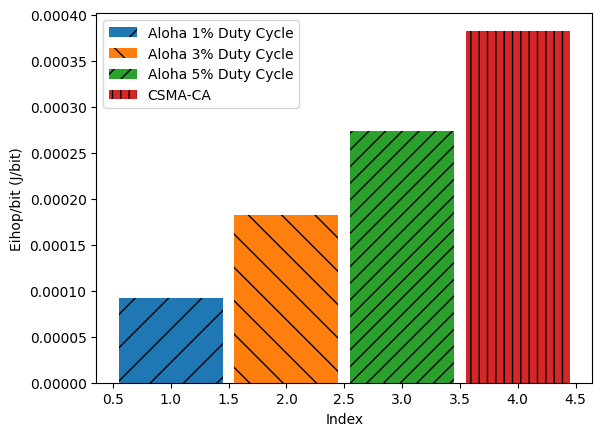

In [72]:
bar_width = 0.9
plt.bar(1, aloha_rdc_final_dfs['1']['Eihop/bit'], bar_width, label='Aloha 1% Duty Cycle', hatch='/')
plt.bar(2, aloha_rdc_final_dfs['3']['Eihop/bit'], bar_width, label='Aloha 3% Duty Cycle', hatch='\\')
plt.bar(3, aloha_rdc_final_dfs['5']['Eihop/bit'], bar_width, label='Aloha 5% Duty Cycle', hatch='//')
plt.bar(4, csma_df_final['Eihop/bit'], bar_width, label='CSMA-CA', hatch='||')

plt.legend()

# Adicionar rótulos para os eixos
plt.xlabel('Index')
plt.ylabel(f'Eihop/bit ({energy_unit}/bit)')

# Mostrar o gráfico
plt.show()

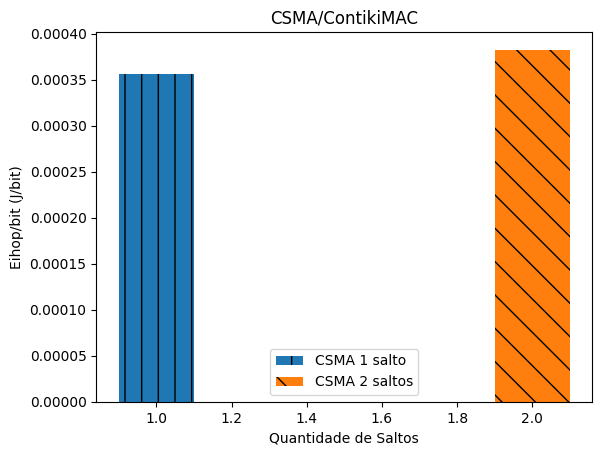

In [53]:
#CSMA
csma_1_hop = csma_df_final[csma_df_final['hops'] == 1]
csma_2_hop = csma_df_final[csma_df_final['hops'] == 2]

plot_energy_per_bit(1, csma_1_hop['Eihop/bit'], 'CSMA 1 salto', {'hatch': '|'})
plot_energy_per_bit(2, csma_2_hop['Eihop/bit'], 'CSMA 2 saltos', {'hatch': '\\'})

plt.legend()

plt.title('CSMA/ContikiMAC')
# Adicionar rótulos para os eixos
plt.xlabel('Quantidade de Saltos')
plt.ylabel(f'Eihop/bit ({energy_unit}/bit)')

# Mostrar o gráfico
plt.show()


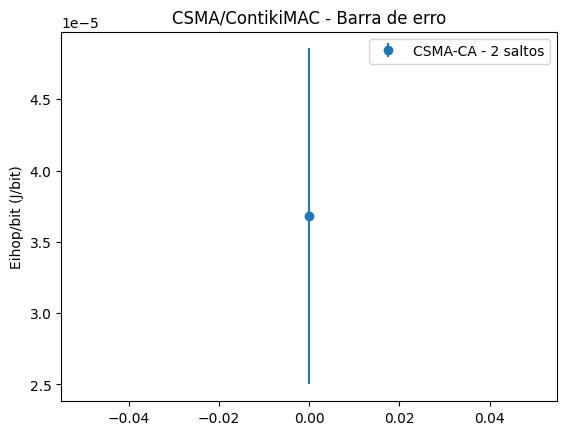

In [26]:
plot_error_bar(0, csma_mean_and_margin_of_error[0], csma_mean_and_margin_of_error[1], csma_label)

plt.legend()

plt.title('CSMA/ContikiMAC - Barra de erro')
# Adicionar rótulos para os eixos
plt.ylabel(f'Eihop/bit ({energy_unit}/bit)')

# Mostrar o gráfico
plt.show()

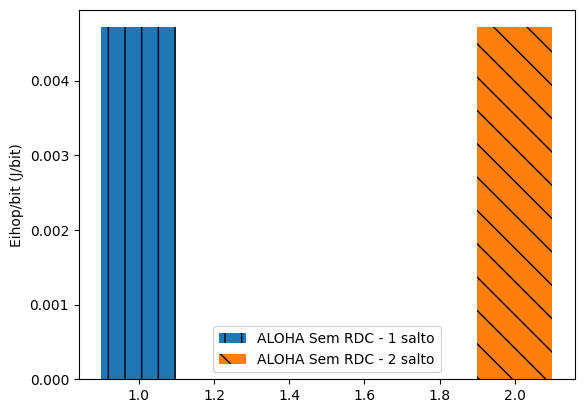

In [54]:
aloha_always_on_1_hop = aloha_always_on_df_final[aloha_always_on_df_final['hops'] == 1]
aloha_always_on_2_hop = aloha_always_on_df_final[aloha_always_on_df_final['hops'] == 2]

plot_energy_per_bit(1, aloha_always_on_1_hop['Eihop/bit'], 'ALOHA Sem RDC - 1 salto', {'hatch': '|'})
plot_energy_per_bit(2, aloha_always_on_2_hop['Eihop/bit'], 'ALOHA Sem RDC - 2 salto', {'hatch': '\\'})


plt.legend()
plt.ylabel(f'Eihop/bit ({energy_unit}/bit)')

# Mostrar o gráfico
plt.show()

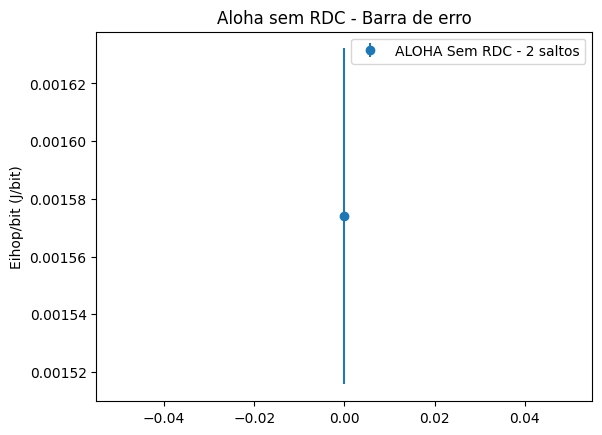

In [28]:
plot_error_bar(0, aloha_always_on_mean_and_margin_of_error[0], aloha_always_on_mean_and_margin_of_error[1], aloha_always_on_label)

plt.legend()

plt.title('Aloha sem RDC - Barra de erro')
# Adicionar rótulos para os eixos
plt.ylabel(f'Eihop/bit ({energy_unit}/bit)')

# Mostrar o gráfico
plt.show()

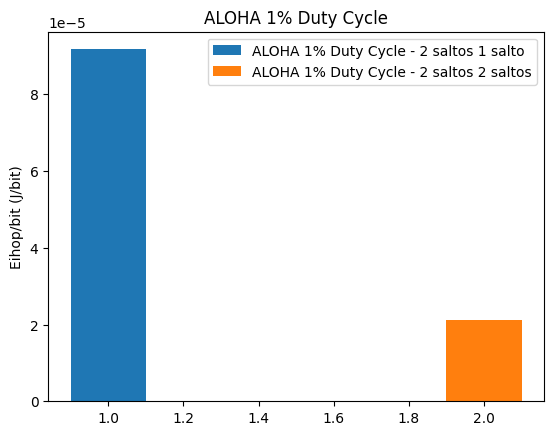

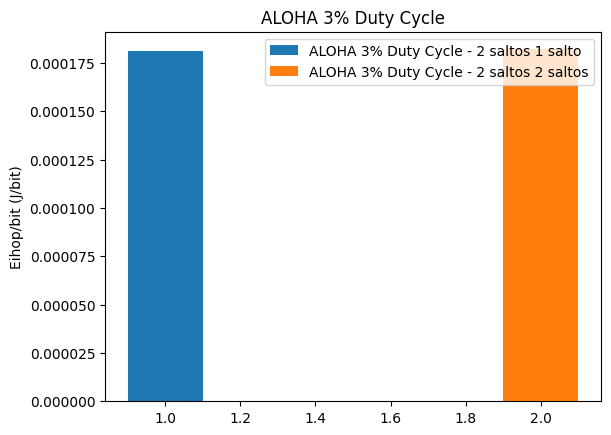

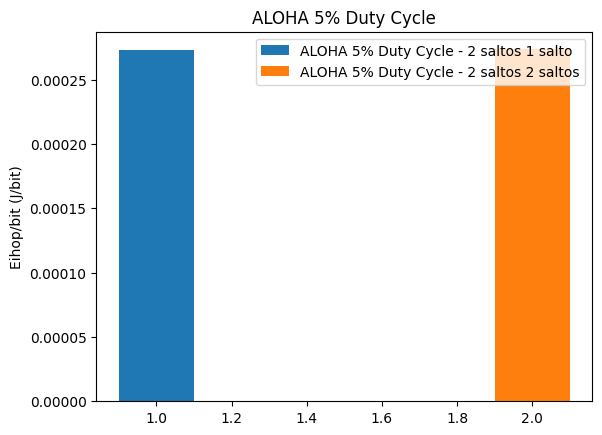

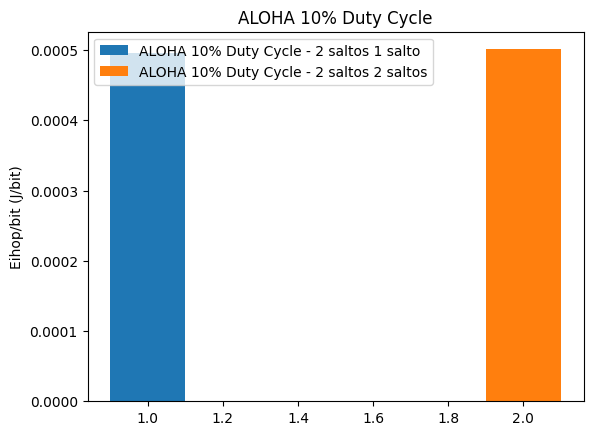

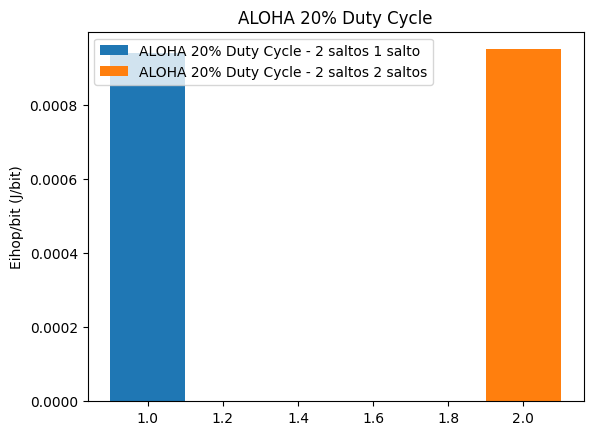

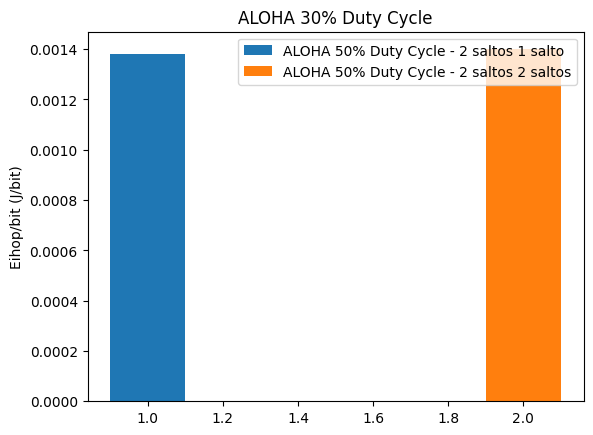

In [29]:

for dc, label in zip(aloha_duty_cycles, aloha_labels):
    one_hop = aloha_rdc_final_dfs[dc][aloha_rdc_final_dfs[dc]['hops'] == 1]
    two_hop = aloha_rdc_final_dfs[dc][aloha_rdc_final_dfs[dc]['hops'] == 2]
    plot_energy_per_bit(1, one_hop['Eihop/bit'], f'{label} 1 salto')
    plot_energy_per_bit(2, two_hop['Eihop/bit'], f'{label} 2 saltos')

    plt.legend()
    plt.ylabel(f'Eihop/bit ({energy_unit}/bit)')
    plt.title(f'ALOHA {dc}% Duty Cycle')
    plt.show()

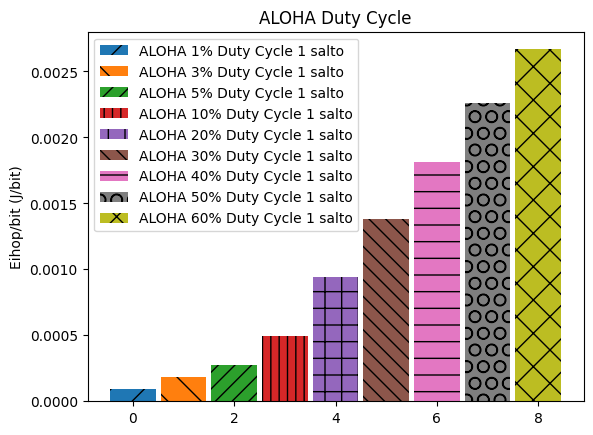

In [64]:
aloha_duty_cycles = ["1", "3", "5", "10", "20", "30", "40", "50", "60"]
aloha_labels = [f'ALOHA {dc}% Duty Cycle' for dc in aloha_duty_cycles]
hatches = ['/', '\\', '//', '||', '+', '\\\\', '-', 'O', 'X']
# Largura das barras
bar_width = 0.9

# Posições iniciais das barras
x = np.arange(len(aloha_duty_cycles))

for i, (dc, label, hatch) in enumerate(zip(aloha_duty_cycles, aloha_labels, hatches)):
    one_hop = aloha_rdc_final_dfs[dc][aloha_rdc_final_dfs[dc]['hops'] == 1]
    # Cria o gráfico de barras
    plt.bar(x[i], one_hop['Eihop/bit'], width=bar_width, label=f'{label} 1 salto', hatch=hatch)

# Adicionar uma legenda
plt.legend()

# Adicionar rótulos para os eixos
plt.ylabel(f'Eihop/bit ({energy_unit}/bit)')
plt.title('ALOHA Duty Cycle')

# Mostrar o gráfico
plt.show()

/home/jonathan/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


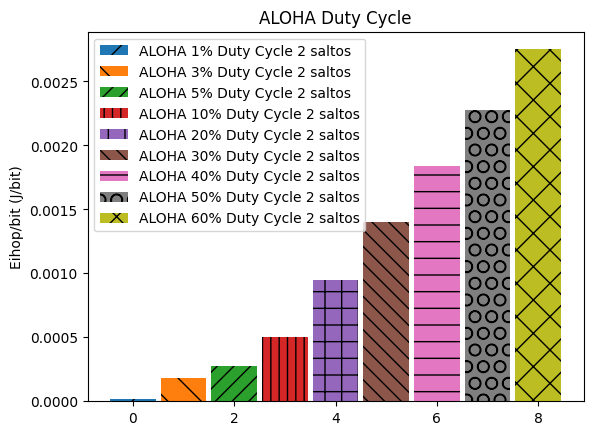

In [65]:
# Largura das barras
aloha_duty_cycles = ["1", "3", "5", "10", "20", "30", "40", "50", "60"]
aloha_labels = [f'ALOHA {dc}% Duty Cycle' for dc in aloha_duty_cycles]
hatches = ['/', '\\', '//', '||', '+', '\\\\', '-', 'O', 'X']
bar_width = 0.9

# Posições iniciais das barras
x = np.arange(len(aloha_duty_cycles))

for i, (dc, label, hatch) in enumerate(zip(aloha_duty_cycles, aloha_labels, hatches)):
    two_hop = aloha_rdc_final_dfs[dc][aloha_rdc_final_dfs[dc]['hops'] == 2]
    # Cria o gráfico de barras
    plt.bar(x[i], two_hop['Eihop/bit'], width=bar_width, label=f'{label} 2 saltos', hatch=hatch)

# Adicionar uma legenda
plt.legend()

# Adicionar rótulos para os eixos
plt.ylabel(f'Eihop/bit ({energy_unit}/bit)')
plt.title('ALOHA Duty Cycle')

# Mostrar o gráfico
plt.show()

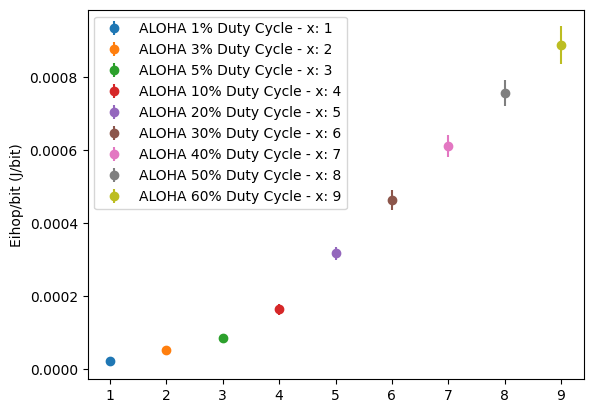

In [62]:
x = 0
aloha_labels = [f'ALOHA {dc}% Duty Cycle - x: {i + 1}' for i, dc in enumerate(aloha_duty_cycles)]
aloha_duty_cycles = ["1", "3", "5", "10", "20", "30", "40", "50", "60"]
for dc, label in zip(aloha_duty_cycles, aloha_labels):
    x += 1
    plot_error_bar(x, aloha_mean_and_margin_of_error[dc][0], aloha_mean_and_margin_of_error[dc][1], label)

# Adicionar uma legenda
plt.legend()

# Adicionar rótulos para os eixos
plt.xlabel('')
plt.ylabel(f'Eihop/bit ({energy_unit}/bit)')

# Mostrar o gráfico
plt.show()

In [33]:
# 1 salto

for dc in aloha_duty_cycles:
  df = aloha_rdc_final_dfs[dc][aloha_rdc_final_dfs[dc]['hops'] == 1]
  print(f'ALOHA {dc}% Duty Cycle - Count: {len(df)}')

print(f'CSMA-CA - Count: {len(csma_df_final[csma_df_final["hops"] == 1])}')
print(f'ALOHA Always On - Count: {len(aloha_always_on_df_final[aloha_always_on_df_final["hops"] == 1])}')

ALOHA 1% Duty Cycle - Count: 369
ALOHA 3% Duty Cycle - Count: 1419
ALOHA 5% Duty Cycle - Count: 2195
ALOHA 10% Duty Cycle - Count: 3912
ALOHA 20% Duty Cycle - Count: 6272
ALOHA 30% Duty Cycle - Count: 6399
ALOHA 40% Duty Cycle - Count: 7452
ALOHA 50% Duty Cycle - Count: 7656
ALOHA 60% Duty Cycle - Count: 7551
CSMA-CA - Count: 7884
ALOHA Always On - Count: 7880


In [34]:
# 2 saltos

for dc in aloha_duty_cycles:
  df = aloha_rdc_final_dfs[dc][aloha_rdc_final_dfs[dc]['hops'] == 2]
  print(f'ALOHA {dc}% Duty Cycle - Count: {len(df)}')

print(f'CSMA-CA - Count: {len(csma_df_final[csma_df_final["hops"] == 2])}')
print(f'ALOHA Always On - Count: {len(aloha_always_on_df_final[aloha_always_on_df_final["hops"] == 2])}')

ALOHA 1% Duty Cycle - Count: 2
ALOHA 3% Duty Cycle - Count: 8
ALOHA 5% Duty Cycle - Count: 10
ALOHA 10% Duty Cycle - Count: 45
ALOHA 20% Duty Cycle - Count: 622
ALOHA 30% Duty Cycle - Count: 4104
ALOHA 40% Duty Cycle - Count: 5433
ALOHA 50% Duty Cycle - Count: 4873
ALOHA 60% Duty Cycle - Count: 4869
CSMA-CA - Count: 7886
ALOHA Always On - Count: 7884


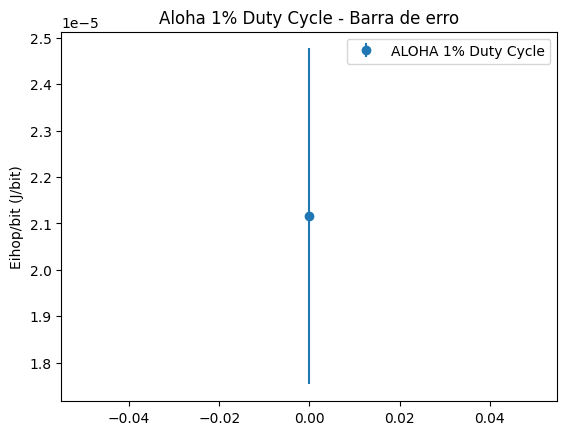

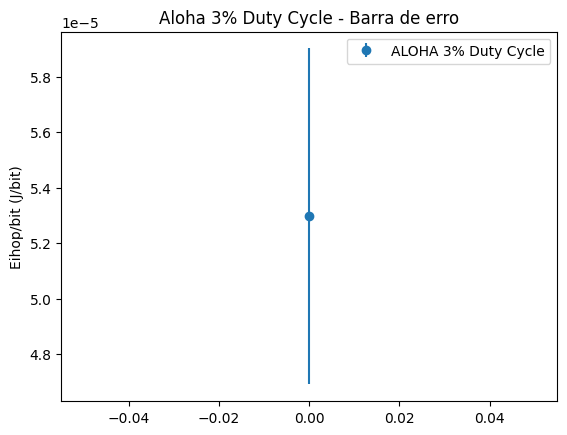

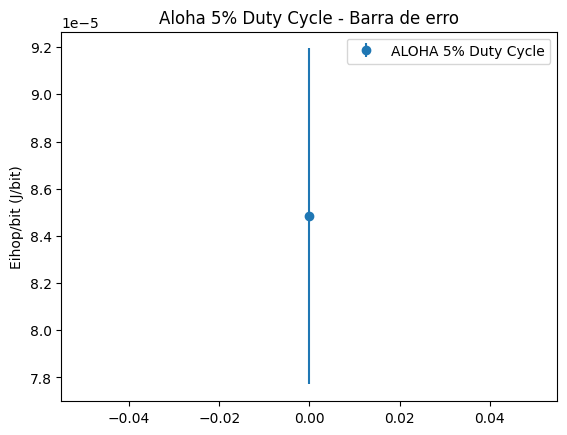

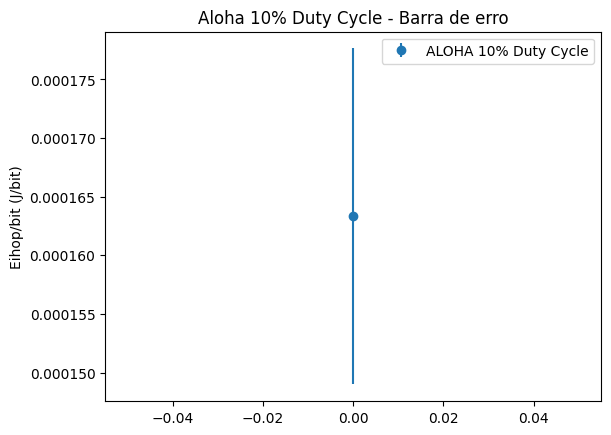

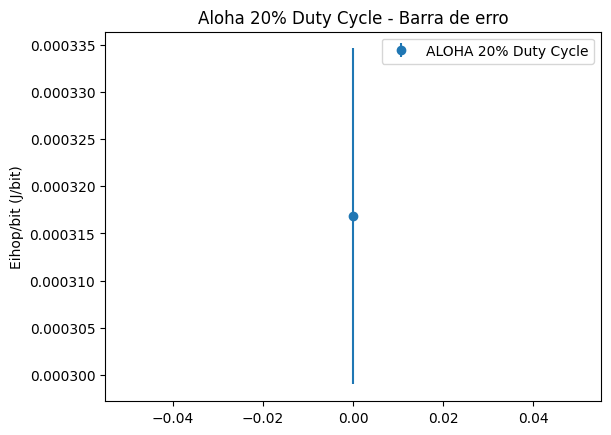

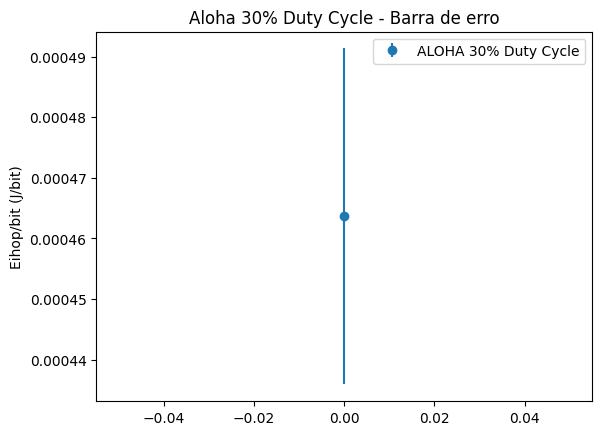

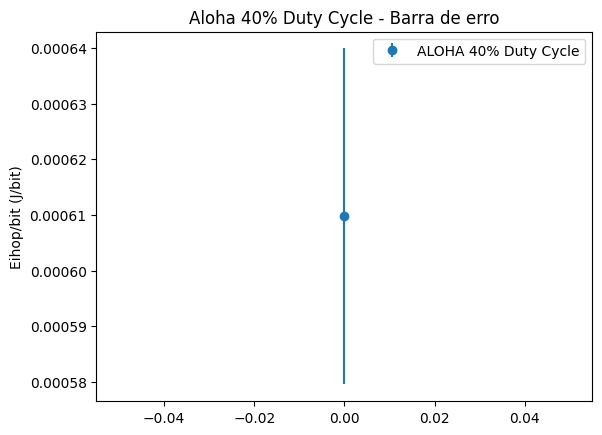

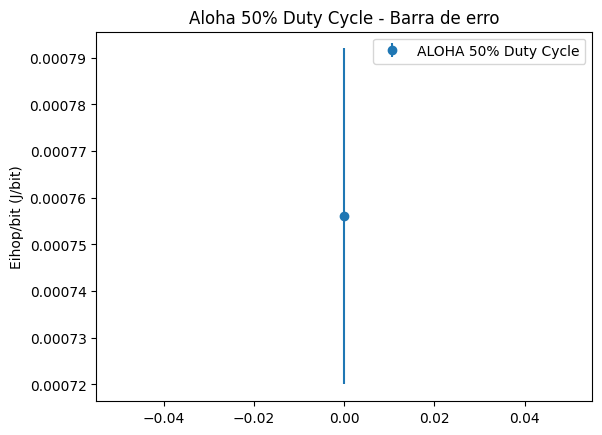

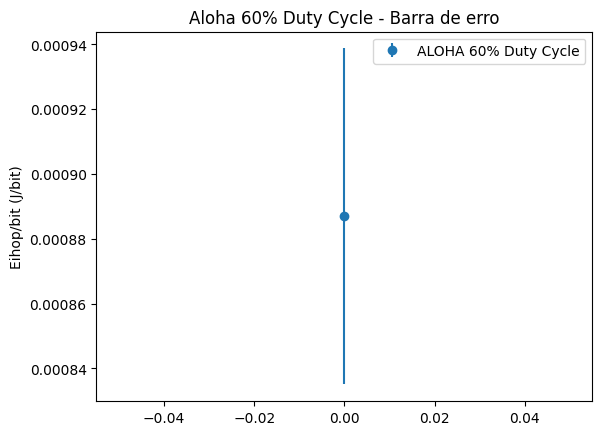

In [35]:
for dc, label in zip(aloha_duty_cycles, aloha_labels):
    plot_error_bar(0, aloha_mean_and_margin_of_error[dc][0], aloha_mean_and_margin_of_error[dc][1], label)
    plt.legend()
    plt.title(f'Aloha {dc}% Duty Cycle - Barra de erro')
    # Adicionar rótulos para os eixos
    plt.ylabel(f'Eihop/bit ({energy_unit}/bit)')
    plt.show()
# Mostrar o gráfico